In [1]:
pip install marker-pdf

In [ ]:
# pip install langchain

In [ ]:
# pip install langchain_community

In [ ]:
# pip install torch torchvision transformers

In [2]:
pip install -U langchain-community

  Using cached langchain_community-0.3.8-py3-none-any.whl.metadata (2.9 kB)
Using cached langchain_community-0.3.8-py3-none-any.whl (2.4 MB)


In [3]:
pip install langchain_qdrant

  Using cached langchain_qdrant-0.2.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached qdrant_client-1.12.1-py3-none-any.whl.metadata (10 kB)
  Using cached grpcio_tools-1.68.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.3 kB)
  Using cached portalocker-2.10.1-py3-none-any.whl.metadata (8.5 kB)
  Using cached protobuf-5.28.3-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached h2-4.1.0-py3-none-any.whl.metadata (3.6 kB)
  Using cached hyperframe-6.0.1-py3-none-any.whl.metadata (2.7 kB)
  Using cached hpack-4.0.0-py3-none-any.whl.metadata (2.5 kB)
Using cached langchain_qdrant-0.2.0-py3-none-any.whl (23 kB)
Using cached qdrant_client-1.12.1-py3-none-any.whl (267 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found e

In [4]:
pip install qdrant_client

In [5]:
pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.6 MB/s eta 0:00:00


In [30]:
from marker.convert import convert_single_pdf
from marker.models import load_all_models


models = load_all_models()
full_text, imaged, out_meta = convert_single_pdf("/content/SpellBook_391834.pdf", models, langs=['en'])

Loaded detection model vikp/surya_det3 on device cuda with dtype torch.float16
Loaded detection model vikp/surya_layout3 on device cuda with dtype torch.float16
Loaded reading order model vikp/surya_order on device cuda with dtype torch.float16
Loaded recognition model vikp/surya_rec2 on device cuda with dtype torch.float16
Loaded texify model to cuda with torch.float16 dtype
Loaded recognition model vikp/surya_tablerec on device cuda with dtype torch.float16


Finding reading order: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]
Recognizing tables: 0it [00:00, ?it/s]


In [ ]:
# print(full_text)

In [ ]:
# imaged

example of code to be adjusted, then push the chunks with metadata to Qdrant

In [31]:
from langchain.text_splitter import MarkdownHeaderTextSplitter

# 1. Initialize MarkdownHeaderTextSplitter with the level of header to split on.
# text_splitter = MarkdownHeaderTextSplitter(levels=["1"])
headers_to_split = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
    ("####", "Header 4"),
    ("#####", "Header 5"),
    ("######", "Header 6"),
]


text_splitter = MarkdownHeaderTextSplitter(
    headers_to_split,
    strip_headers=False
)

chunks = text_splitter.split_text(full_text)




levare noise dai chunks


Blip fa un po' cagare, andrebbe cambiato in meglio

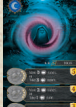

In [32]:
imaged["11_image_1.png"]

___________________________________ Trying to remove not useful
images____________________________________
(doesnt work)

In [ ]:
# # prompt: read file from openAI.txt and initialize gpt 4o mini

# # Assuming 'openAI.txt' is in the current working directory.  If not,
# # provide the full path.
# from langchain.chat_models import ChatOpenAI

# try:
#     with open("/content/OpenAI.txt", "r") as f:
#         api_key = f.readline().strip() # Read the first line (API key)

# except FileNotFoundError:
#     print("Error: 'openAI.txt' not found. Please ensure the file exists and contains your API key.")
#     api_key = None # or raise an exception, depending on your needs

# if api_key:
#     import os
#     os.environ["OPENAI_API_KEY"] = api_key

#     # Initialize gpt-4-1106-preview (or any other desired model) using langchain

#     try:
#       llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
#       print("GPT-4 initialized successfully!")
#     except Exception as e:
#         print(f"An error occurred while initializing the GPT model: {e}")

<ipython-input-26-6fd50d9e3810>:22: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)


GPT-4 initialized successfully!


In [ ]:
# from transformers import BlipProcessor, BlipForConditionalGeneration
# from PIL import Image

# # Load the BLIP model and processor
# processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
# model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [ ]:
# image_descriptions = {}
# chunk_number = 0
# for chunk in chunks:
#     image_descriptions[chunk_number] = []  # Initialize as an empty list for this chunk
#     for image_name in imaged:
#         if image_name in chunk.page_content:
#             image = imaged[image_name].convert("RGB")
#             #Generate caption
#             inputs = processor(image, return_tensors="pt")
#             outputs = model.generate(**inputs)
#             caption = processor.decode(outputs[0], skip_special_tokens=True)
#             image_descriptions[chunk_number].append((image_name, caption))  # Append as a tuple
#     chunk_number += 1
# image_descriptions

In [ ]:
# from langchain.prompts import PromptTemplate

# template_string = '''
# System: Your task is to process the given {chunk} and {image_descriptions}, this last dictionary contains image names that you will find in chunk and also their brief description.
# - Do not modify the content semantically.
# - Remove image references if they seem misplaced or irrelevant to the game explanation, base yuor reasoning on the image description and its surrounding context.
# '''

# PROMPT = PromptTemplate(
#     template=template_string,
#     input_variables=["chunk", "image_descriptions"]
# )

In [ ]:
# # prompt: create a chain with the llm and the prompt string giving input the variables

# from langchain.chains import LLMChain
# chunk_number = 0

# # Example usage of the LLMChain
# for chunk in chunks:
#     # Prepare the input for the prompt

#     prompt_input = {"chunk": chunk.page_content, "image_descriptions": image_descriptions[chunk_number]}

#     # Create an LLMChain
#     llm_chain = LLMChain(llm=llm, prompt=PROMPT)
#     chunk_number += 1
#     # Run the LLMChain
#     try:
#         response = llm_chain.run(prompt_input)
#         # Update the chunk's page content with the processed response
#         chunk.page_content = response
#         # print("Processed Chunk:\n", response) # or handle the response as needed
#     except Exception as e:
#         print(f"An error occurred during LLMChain execution: {e}")

_____________________________________________

In [33]:
import base64
from io import BytesIO

# Assuming `imaged` contains PIL Image objects or file paths
transformed_imaged = {key.lower(): value for key, value in imaged.items()}
for chunk in chunks:
    relevant_images = {}
    for image_name in transformed_imaged.keys():
        if image_name in chunk.page_content.lower():
            # Convert PIL Image to base64
            image = imaged[image_name]  # This assumes it's a PIL Image
            buffer = BytesIO()
            image.save(buffer, format="PNG")  # Adjust format as needed
            base64_image = base64.b64encode(buffer.getvalue()).decode('utf-8')
            relevant_images[image_name]= base64_image

    # 4. Assign images as metadata.
    chunk.metadata['images'] = relevant_images


QUESTO CHUNCK E LA RELATIVA IMMAGINE SAREBBE MEGLIO PULIRLI

IMAGE


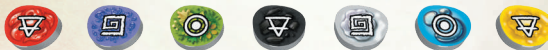

IMAGE


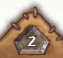

In [34]:
# prompt: convert the chunks[1].metadata['images' to base64 and display them]

# Assuming chunks[1] exists and has the 'images' metadata
import base64
from IPython.display import Image, display

for base64_image in chunks[2].metadata['images']:
      print("IMAGE")
      image_data = base64.b64decode(chunks[2].metadata['images'][base64_image])
      display(Image(data=image_data))


In [79]:
chunks[0]

Document(metadata={'images': {'0_image_0.png': 'iVBORw0KGgoAAAANSUhEUgAAABAAAAAcCAIAAADnU6hNAAADLklEQVR4nEWRvY4lWRGEv8g8VXX/unsGaYQzWgsHhHB4AF6AF+FNeCQspHVAwsBESCthwDDs/07PdPe9t+qcjDUuiFQ4KWVEKCL1+9/9FpNTSsIatWFDDg+PLV22ByYiI0PRxri4vBYguk0plLlIymyJavSqLjsoW+3h/K53bW52duMIskXr2WZCTikzYrZkal2rtQ//4jpUVcXeLaMNaxAxT0w57dvh/th2S7RJkd/42H75i33f1EdUZ7v2y7m7K+ZxOsXpzfLq7cP+9ewY6/V5/aH//Qvar37zMzQxFrbz2F6ePz2FM1/fH057PVTMdy/rq8fr7vI0vv7+qy+fH9vxs9dwtN5gEf3YP0ZsfRD98f0X7/7w+bs//63WMbWcTofdctg1VzA+wSdiwYkbTXn56uXr93/54w9/+mt+8OnhlC0VGZJavP21P33L+Xu02Gs9r9KFD0/fvVv/+W/1nO728/3xFBnLwn5ZGlNqtyd/yrTHa/N/3L9b12vLOp6m0/VOy+nu4XBYduDIqeFi2lOPXD96PFErPs37c12floWpzcfTsluW/W6qSEHDM9NM21Owfcv56utHbRdwaGrz0qa5TdPUpo4NgQsLEiW+UyxKaCdFk0ohpSQhQJhguiP3xIQaIV59xqufk+EaHiEXVd3e7A4mGl5RoYGC2HkfVNDexO5LtQs2lk05ShGphnYoYSYqUqNfwo81r7vTYq7dDDQ55MIAjTFQEWDIoCbUqOFesgMnle7pslKoMZ6Q0IwTGTXyiA6Q2LoBBEKBGobqhKgLfWPA9YJnYrldGVkqyWDTePmGUUwLfWXbYKWf3c8YpP/BUmGDG6P7+UzrOgSHkA+cy5f3l+1DZlOkpCBUrnJkNOamDVK0e+hyh6Beanumltu7JAGh

In [36]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import base64
from io import BytesIO

# Initialize a global list to store images marked for removal
images_to_remove = []

# Variable to track the current chunk index
current_chunk_index = 0

# Decode base64 image to binary data
def decode_image(image_base64):
    try:
        return base64.b64decode(image_base64)
    except Exception as e:
        print(f"Error decoding image: {e}")
        return None

# Display images for the current chunk and set up navigation
def process_images():
    global current_chunk_index

    # Clear output to refresh display
    clear_output(wait=True)

    # Display navigation
    nav_box = widgets.HBox([
        widgets.Label(f"Chunk {current_chunk_index + 1}/{len(chunks)}"),
        widgets.Button(description="Next Chunk", on_click=next_chunk)
    ])
    display(nav_box)

    # Get the current chunk
    chunk = chunks[current_chunk_index]

    # Ensure images exist
    if 'images' not in chunk.metadata or not chunk.metadata['images']:
        print(f"No images found for chunk {current_chunk_index}")
        return

    # Create widgets for all images
    image_widgets = []
    for image_name, image_base64 in chunk.metadata['images'].items():
        # Decode image data
        image_data = decode_image(image_base64)
        if not image_data:
            print(f"Invalid image data for {image_name}")
            continue

        # Display image and add click functionality
        image_widget = widgets.Image(
            value=image_data,
            format='png',
            width=300,
            height=400
        )
        label = widgets.Label(image_name)

        # Button to select image for removal
        remove_button = widgets.Button(description=f"Remove {image_name}")
        remove_button.image_name = image_name
        remove_button.on_click(add_to_removal_list)

        image_widgets.append(widgets.VBox([image_widget, label, remove_button]))

    display(widgets.VBox(image_widgets))

# Add image to the removal list
def add_to_removal_list(button):
    image_name = button.image_name
    if image_name not in images_to_remove:
        images_to_remove.append(image_name)
        print(f"Marked '{image_name}' for removal.")
    else:
        print(f"'{image_name}' is already marked for removal.")

# Go to the next chunk
def next_chunk(_):
    global current_chunk_index
    if current_chunk_index < len(chunks) - 1:
        current_chunk_index += 1
        process_images()
    else:
        print("No more chunks to process.")




In [91]:
#keep re-running, next chunk button doesnt work
current_chunk_index+=1
process_images()

In [77]:
images_to_remove

['0_image_0.png',
 '0_image_1.png',
 '1_image_3.png',
 '2_image_1.png',
 '4_image_0.png',
 '5_image_1.png',
 '9_image_3.png',
 '9_image_4.png',
 '10_image_1.png',
 '10_image_5.png',
 '11_image_0.png',
 '13_image_1.png',
 '13_image_2.png',
 '14_image_0.png',
 '14_image_1.png',
 '15_image_0.png',
 '15_image_1.png',
 '15_image_3.png',
 '15_image_4.png',
 '15_image_5.png']

In [80]:
# Remove images from metadata and page_content
for chunk in chunks:
    for image_name in images_to_remove:
        # Remove from metadata
        if 'images' in chunk.metadata and image_name in chunk.metadata['images']:
            del chunk.metadata['images'][image_name]

        # Remove from page_content (handle various potential formats)
        for pattern in [f"[{image_name}]({image_name})",
                        f"[{image_name}]({image_name.lower()})",
                        f"[{image_name}]({image_name.upper()})",
                        f"[{image_name.lower()}]({image_name.lower()})",
                        f"[{image_name.upper()}]({image_name.upper()})",
                        image_name, image_name.lower(), image_name.upper()]:
            chunk.page_content = chunk.page_content.replace(pattern, "")

In [83]:
chunks[-1]

Document(metadata={'Header 1': 'Designer / Artwork', 'Header 2': 'Frequently Forgotten Rules', 'images': {}}, page_content="## Frequently Forgotten Rules  \n![15_Image_4.Png](15_Image_4.Png)  \n![15_Image_5.Png](15_Image_5.Png)  \nA player's pool is strictly limited to 9 Materia at all times. The primary action Store 1 Materia is performed at Midday. The players must therefore decide to store before learning a Spell (Evening). Transforming 3 Materia showing an identical rune into a wild Materia can only be performed when the player learns a Spell. It cannot be done for any other effect. The effect is only applied when the player learns the Spell, and must be applied immediately. For learned Spells showing a phase symbol ( Morning, Midday, or Evening), the player may use the effect at the level learned or any lower level. For Spells that do not have a phase symbol, only the effect of the level learned may be applied (you cannot use lowerlevel effects of these Spells).  \nThis product ha

In [84]:
#add metadata
# for txt_file in tqdm(txt_files):
#     # Read text content from each TXT file
#     with open(os.path.join(path, txt_file), 'r', encoding='utf-8') as file:
#         text = file.read()
#     txt_texts.append(text)

# Read text content from each TXT file
# txt_dict = [{"game_name": txt_file.removesuffix(".txt").split("_")[0], "game_id": txt_file.removesuffix(".txt").split("_")[1]} for txt_file in txt_files]

book_name = "SpellBook_391834"
txt_dict = {
        "game_name": book_name.split("_")[0],
        "game_id": book_name.split("_")[1]
    }


In [85]:

# Add txt_dict to the metadata of each chunk
for chunk in chunks:
    chunk.metadata['game_name'] = txt_dict['game_name']
    chunk.metadata['game_id'] = txt_dict['game_id']

In [86]:
chunks[0].metadata

{'images': {'1_image_0.png': 'iVBORw0KGgoAAAANSUhEUgAAAMAAAAE8CAIAAAAZmSmGAAEAAElEQVR4nJT9ebBl6XEfiOXyfeecu7/91au9a+19x06AbJAAAZAUKJEUqY205JE5M2ErQoqww8t4HGFHjB0OhcejsSWO1lGMRFGkKJEUSYALiB2NRqP36qqufX37evdzzvdlpv84974qgBOOmRvVFa/rVd13zzn5Zf7yl7/MxDd+7x8ltSyYaB7RwHnHaaIqWpQAgN47JjEDMwBw3iE7yUMZClDztYy8AzFQkxhUjbM0SbyqahQzY0YzMzNAAgAwBQAkRiIAAFWNGvJcQumyOjnSskAgdI6YAMkAAAEMADTkIYokiUMmRCb2Lk0MEQkR0ExNJJalRkNmTrxjQjARA0TnWNUQwQBiUFMFIucdJx4MJIiZITl2IKJgAEjInBCx84pgiOS85IWGEogMAcpxLEtjZ4AWA5gxExIBOTQLZSFlIO85SRjJAMix8w4AAapLQmKc3BMFYHI+BajukJqZqWqMAMBZzaWJhVIBDYnZOeYYAiAyMzlHRMioIWoZRBWYkBgIEQABAQls8lMn7w9mAGiGgIgGAEBM5AAQLKqKiIZBV0Z9kwhgYNVHRkAEQGREQwRAIiSHYE5FFMAiKCASgHfkvUNfRlFVQFRAlyRmCmZIhIjkHUHUIIYAYqDiHCO7UEYLISpY9fEJmdlU1Ayqp1cZgwEYIKIRYuJS35SyFDMRJSJQ07JUQk5STDyoIqIBahiFPE9c28AMFVAFgMDAEAgAEBCRHYMZGGgETjUEEXVp6pwPIUgI5BwlTsUsxlgUYABETEDEQighmCiwc6kncqgRERAJCBHZFIq8cEnik6SIKiKIDERIVF0PAIKZqMSyBANABDBVVVWkyeU/fEUAi4AAxIiEOHnKRmhqUpQSIwAQO3MOEBERkBARAcyseqCISESAgAhmBmZmJqGcWCgxOkL4AQ

In [87]:
def read_token_from_file(file_path="token.txt"):
    with open(file_path, "r") as file:
        return file.read().strip()

In [88]:
from qdrant_client import QdrantClient
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import OpenAIEmbeddings  # Correct import path for OpenAI embeddings
import os

COLLECTION_NAME = "automatic_ingestion"
os.environ["OPENAI_API_KEY"] = read_token_from_file("/content/OpenAI.txt")
URL=read_token_from_file("/content/qdrant_URL.txt")
API_KEY=read_token_from_file("/content/qdrant.txt")
# Specify the folder path
# folder_path = "C:\\Users\\fiori\\OneDrive\\Documenti\\Rulebooks"
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

In [89]:
def add_embeddings_to_qdrant(docs_processed, URL, API_KEY, OPENAI_KEY, collection_name="test_2"):
    """Create embeddings for documents and add them to Qdrant."""

    URL=URL
    API_KEY=API_KEY

    if OPENAI_KEY:
        embedding_model = OpenAIEmbeddings(
            model="text-embedding-ada-002",  # Specify the desired OpenAI embedding model
        )

    else:
        embedding_model = HuggingFaceEmbeddings(
            model_name=EMBEDDING_MODEL_NAME,
            multi_process=True,  # Enable multiprocessing
            model_kwargs={"device": "cuda"},
            encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
        )


    vector_store = QdrantVectorStore.from_documents(
        docs_processed,
        embedding_model,
        url = URL,
        #prefer_grpc=True,
        api_key=API_KEY,
        collection_name=collection_name,
        force_recreate = False
    )

In [90]:
add_embeddings_to_qdrant(chunks, URL, API_KEY, os.environ["OPENAI_API_KEY"], COLLECTION_NAME)

<ipython-input-89-80bcea435d12>:8: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_model = OpenAIEmbeddings(
